# Detection of anomalies with possible localization 👾

# Model 🏛

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

In [ ]:
# DOWNSAMPLING RESIDUAL BLOCK
class DownsamplingResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DownsamplingResidualBlock, self).__init__()

    self.main_branch=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
    )

    self.skip_connection=nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
    )

  def forward(self, x):
    residual=self.skip_connection(x)
    x=self.main_branch(x)
    out=x+residual
    return out

In [ ]:
# UPSAMPLE RESIDUAL BLOCK
class UpsampleResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UpsampleResidualBlock, self).__init__()

    self.main_branch=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
      )

    self.skip_connection=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels,kernel_size=2,stride=2),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    residual=self.skip_connection(x)
    x=self.main_branch(x)
    out=x+residual
    return out

In [ ]:
import torch
import torch.nn as nn

class AutoEncoder2D(nn.Module):
    def __init__(self, input_resolution=256, in_channels=3, base_channels=32, z_dim=512):
        """
        Args:
            input_resolution (int): 256 or 512.
            in_channels (int): Number of input channels (default 3 for RGB).
            base_channels (int): Number of filters in the first layer.
            z_dim (int): Dimension of the latent vector (default 512 as per proposal).
        """
        super(AutoEncoder2D, self).__init__()

        # 1. Validate Input
        assert input_resolution in [256, 512], "Resolution must be 256 or 512"
        self.input_resolution = input_resolution

        # 2. Initial Convolution
        # Input: [B, 3, Res, Res]
        self.encoder_init = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(base_channels)
        )

        # 3. Construct Variable Encoder Depth
        # We need to downsample until we reach 4x4 spatial size to keep parameters low.
        # 256 -> 128 -> 64 -> 32 -> 16 -> 8 -> 4 (6 Blocks)
        # 512 -> 256 -> 128 -> 64 -> 32 -> 16 -> 8 -> 4 (7 Blocks)

        self.enc_blocks = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()

        # Define channel progression: 32 -> 64 -> 128 -> 256 -> 256...
        # We cap channels at 256 (base*8) to save memory
        max_c = base_channels * 8

        current_res = input_resolution
        in_c = base_channels

        # Loop until we reach 4x4 spatial resolution
        while current_res > 4:
            out_c = min(in_c * 2, max_c)

            # Add Encoder Block (Downsampling)
            self.enc_blocks.append(DownsamplingResidualBlock(in_c, out_c))

            # Add Decoder Block (Upsampling) - prepending to reverse later
            self.dec_blocks.insert(0, UpsampleResidualBlock(out_c, in_c))

            in_c = out_c
            current_res //= 2

        # 4. Bottleneck (Dense Vector)
        # At this point, spatial dim is always 4x4, and channels are max_c (256)
        self.feature_size = max_c * 4 * 4 # 256 * 16 = 4096 inputs

        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(self.feature_size, z_dim)
        self.fc_decode = nn.Linear(z_dim, self.feature_size)
        self.unflatten = nn.Unflatten(1, (max_c, 4, 4))

        # 5. Final Reconstruction
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid() # MVTec images are normalized [0,1]
        )

    def forward(self, x):
        # --- Encoder ---
        x = self.encoder_init(x)

        for block in self.enc_blocks:
            x = block(x)

        # --- Bottleneck ---
        x = self.flatten(x)
        z = self.fc_encode(x) # Latent Vector Z (Size 512)

        # --- Decoder ---
        x = self.fc_decode(z)
        x = self.unflatten(x)

        for block in self.dec_blocks:
            x = block(x)

        # --- Output ---
        x = self.final_conv(x)
        return x

In [ ]:

size_str = "256" #@param [256, 512]
size = int(size_str)

z_dim_sel = "128" #@param [128, 256, 512]
z_dim_sel = int(z_dim_sel)

base_ch_sel = "64" #@param [32, 64, 128]
base_ch_sel = int(base_ch_sel)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


# Dataset 📚

**IMPORTANT 📢**

Set the **extract_path** variable to the folder containing the dataset in your Google Drive so that the project can run in your session.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.models as models
from torchvision import transforms
import glob
import os
from torchsummary import summary
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the directory where you want to extract the files
# Fernando:
extract_path = '/content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/F-Code/'

# Others:
#extract_path = '/content/drive/MyDrive/Project/F-Code/'

# Choose training category, f.eks. "bottle", "capsule", "grid", ...
category = "capsule"

# Construct the full path to the 'capsule' dataset directory
test_dir = os.path.join(extract_path, category+"/"+category+"/test")
train_dir = os.path.join(extract_path, category+"/"+category+"/train")

# Initialize an empty list to store test image paths
test_list = []
train_list = []

# Recursively find all image files (png, jpg, jpeg) within the 'test' directory
for ext in ('*.png', '*.jpg', '*.jpeg'):
    test_list.extend(glob.glob(os.path.join(test_dir, '**', ext), recursive=True))
    train_list.extend(glob.glob(os.path.join(train_dir, '**', ext), recursive=True))

print(f"- Found {len(test_list)} test images.")
print(f"- Found {len(train_list)} train images.")

- Found 132 test images.
- Found 219 train images.


## Train Dataset

In [ ]:
# TRAIN DATASET

from torch.utils.data import Dataset
from PIL import Image

#used to create the train_list and val_list
class MVTecDataset(Dataset):
    def __init__(self, file_list, transform=None):
      """
      file_list: a list of paths to images, e.g. the good-path for phase1, normal_train_images
      transform=resize, ToTensor, normalize, in training: image_train_transforms, image_val_transforms
      """
      self.file_list = file_list
      self.transform = transform

    def __len__(self):
      return len(self.file_list) #number of samples=length of file-list

    def __getitem__(self, idx):
      image_path = self.file_list[idx] #find path to image

      image = Image.open(image_path).convert("RGB") #open image

      if self.transform is not None:
        image=self.transform(image) #transform image

      return image


### Image transforms

In [ ]:
#DATA augmentation for training-set
image_train_transforms = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.RandomRotation(degrees=5),
    # ---------------------------
    transforms.ToTensor(),

])

#DATA augmentation on validation-set
image_val_transforms = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),

])

#DATA augmentation on test-set
image_test_transforms = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),

])

### Train Dataloader

Split ratio recommendations:

- 80/20: Standard baseline for MVTec.Robust threshold calibration.
- 90/10: Small datasets (<100 images) Maximizes model exposure to normal features.


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

#split the list of normal images
train_list, val_list=train_test_split(train_list,
                                      test_size=0.2,
                                      random_state=42,
                                      shuffle=True)
#check
print("Number of training images", len(train_list))
print("Number of validation images", len(val_list))

#make dataset-objects

train_data=MVTecDataset(train_list, transform=image_train_transforms)
val_data=MVTecDataset(val_list, transform=image_val_transforms)

Number of training images 175
Number of validation images 44


In [ ]:
batch_size=16 #@param {type:"slider", min:1, max:20}

train_loader=DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True #for training

)

val_loader=DataLoader(
    dataset=val_data,
    batch_size=1,
    shuffle=False #for validation
)

print("Number of batches(train):", len(train_loader))
print("Number of batches(val):", len(val_loader))

Number of batches(train): 11
Number of batches(val): 44


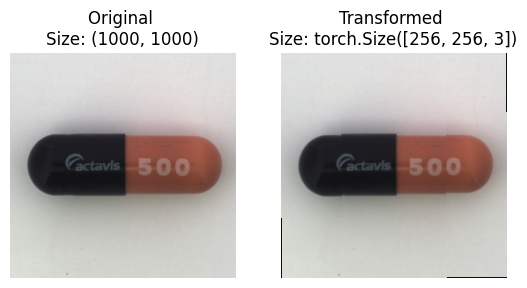

In [ ]:
#Plotting to show augmentation
from PIL import Image
import matplotlib.pyplot as plt

random_image_path = train_list[2]

def image_transformation_plot(image_path: str, transform: transforms.Compose) -> None:
    """
    Plots and compares selected image before and after transformation.

    Args:
        image_path (Path): Path of image to plot
        transform (Pytorch Transforms): Selected transforms composition
    """
    f = Image.open(image_path)

    fig, ax = plt.subplots(1, 2)
    plt.gray()
    ax[0].imshow(f)
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")

    transformed_image = transform(f).permute(1, 2, 0)
    ax[1].imshow(transformed_image)
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

image_transformation_plot(random_image_path, image_train_transforms)

## Test dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

#used to create the train_list and val_list
class MVTecDatasetTest(Dataset):
    def __init__(self, file_list, transform=None):
      """
      file_list: a list of paths to images, e.g. the good-path for phase1, normal_train_images
      transform=resize, ToTensor, normalize, in training: image_train_transforms, image_val_transforms
      """

      self.file_list = file_list
      self.transform = transform

    def __len__(self):
      return len(self.file_list) #number of samples=length of file-list

    def __getitem__(self, idx):
      image_path = self.file_list[idx] #find path to image

      image = Image.open(image_path).convert("RGB") #open image

      # Determine label based on filename (simple approach for this dataset)
      label = 0 if 'good' in image_path else 1 # 1 for anomaly, 0 for good images

      if self.transform is not None:
        image=self.transform(image) #transform image

      return image, label

In [ ]:
test_data=MVTecDatasetTest(test_list, transform=image_test_transforms)

test_loader=DataLoader(
    dataset=test_data,
    batch_size=1,
    shuffle=False #for validation
)

# Training (Phase 1) 💪

## Combined loss

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure
import torch.nn.functional as F

ssim_measure = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=5).to(device)

def combined_loss(outputs, inputs, alpha=0.5):
    """
    Simplified Combined Loss for data that is NOT normalized (Range [0, 1]).

    Args:
        outputs: Model reconstruction (Sigmoid output, Range [0, 1])
        inputs: Original image (ToTensor output, Range [0, 1])
        alpha: Weight for MSE. (1-alpha) is for SSIM.
    """
    # 1. MSE Loss (Works directly on [0, 1] data)
    mse_loss = F.mse_loss(outputs, inputs)

    # 2. SSIM Loss
    # Since inputs/outputs are already [0, 1], we pass them directly.
    # We strictly clamp just to be safe against floating point overshoots.
    outputs_clamped = torch.clamp(outputs, 0, 1)
    inputs_clamped = torch.clamp(inputs, 0, 1)

    # Calculate SSIM (1 - Similarity)
    # Ensure ssim_measure is initialized with data_range=1.0 (default)
    ssim_val = ssim_measure(outputs_clamped, inputs_clamped)
    structural_loss = 1 - ssim_val

    # 3. Weighted Sum
    return (alpha * mse_loss) + ((1 - alpha) * structural_loss)

## Training with accumulation function

In [ ]:
def train_autoencoder_with_accumulation(model, optimizer, train_loader, val_loader,
                                        epochs=20, accumulation_steps=8, device="cuda", save_best_path=None,alpha=0.5):
    train_loss_epoch = []
    val_loss_epoch = []
    best_val_loss = float("inf")

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        running_train_loss = 0.0

        # Reset gradients at the start of the epoch
        optimizer.zero_grad()

        for i, batch in enumerate(train_loader):
            inputs = batch.to(device)
            outputs = model(inputs)

            # 1. Calculate loss as usual
            loss = combined_loss(outputs, inputs, alpha)

            # 2. Normalize the loss to account for accumulation
            # This ensures gradients are averaged over the simulated larger batch
            loss = loss / accumulation_steps

            # 3. Accumulate gradients
            loss.backward()

            # 4. Perform optimizer step only after N batches
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            # Log the full loss for tracking
            running_train_loss += (loss.item() * accumulation_steps) * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_loss_epoch.append(epoch_train_loss)

        # -------- VALIDATION (Same as before) ----------
        model.eval()
        running_vali_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch.to(device)
                outputs = model(inputs)
                v_loss = combined_loss(outputs, inputs, alpha)
                running_vali_loss += v_loss.item() * inputs.size(0)

        epoch_vali_loss = running_vali_loss / len(val_loader.dataset)
        val_loss_epoch.append(epoch_vali_loss)

        if epoch_vali_loss < best_val_loss:
            best_val_loss = epoch_vali_loss
            if save_best_path is not None:
                torch.save(model.state_dict(), save_best_path)

        print(f"Epoch: {epoch+1} | Eff. Batch: {batch_size * accumulation_steps} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_vali_loss:.6f}")

    return train_loss_epoch, val_loss_epoch

## Train execution

In [ ]:
#LOSS, MODEL AND OPTIMIZER, RUNNING TRAINING

model=AutoEncoder2D(input_resolution=size,base_channels=base_ch_sel,z_dim=z_dim_sel,in_channels=3).to(device)

#where to store the best model
model_name = "configh9" # @param {"type":"string","placeholder":"configf1"}
best_model_path=extract_path+model_name+".pth"

# HYPERPARAMETER SETUP FOR RUN 1
EFFECTIVE_BATCH_SIZE = 32 # @param {"type":"slider","min":1,"max":100,"step":1}
ACCUMULATION_STEPS = EFFECTIVE_BATCH_SIZE // batch_size # Automatically calculates 4 or 8
ALPHA = 0.1 # @param {"type":"slider","min":0.1,"max":0.9,"step":0.1}
LEARNING_RATE = 0.0001 # @param {"type":"number","placeholder":"0.0001"}
W_DECAY = 1e-5 # @param {"type":"number","placeholder":"1e-5"}
EPOCHS = 150 # @param {"type":"slider","min":10,"max":1000,"step":10}

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=W_DECAY)

train_losses, val_losses = train_autoencoder_with_accumulation(
    model,
    optimizer,
    train_loader,
    val_loader,
    epochs=EPOCHS,                 # Give it time to converge
    accumulation_steps=ACCUMULATION_STEPS,
    device=device,
    save_best_path=best_model_path,
    alpha=ALPHA                  # Balanced start
)

Epoch: 1 | Eff. Batch: 32 | Train Loss: 0.822040 | Val Loss: 0.321913
Epoch: 2 | Eff. Batch: 32 | Train Loss: 0.421066 | Val Loss: 0.294013
Epoch: 3 | Eff. Batch: 32 | Train Loss: 0.339840 | Val Loss: 0.269086
Epoch: 4 | Eff. Batch: 32 | Train Loss: 0.307827 | Val Loss: 0.261337
Epoch: 5 | Eff. Batch: 32 | Train Loss: 0.279371 | Val Loss: 0.252514
Epoch: 6 | Eff. Batch: 32 | Train Loss: 0.272352 | Val Loss: 0.246899
Epoch: 7 | Eff. Batch: 32 | Train Loss: 0.265875 | Val Loss: 0.244224
Epoch: 8 | Eff. Batch: 32 | Train Loss: 0.261887 | Val Loss: 0.244675
Epoch: 9 | Eff. Batch: 32 | Train Loss: 0.283161 | Val Loss: 0.252357
Epoch: 10 | Eff. Batch: 32 | Train Loss: 0.257100 | Val Loss: 0.247109
Epoch: 11 | Eff. Batch: 32 | Train Loss: 0.253176 | Val Loss: 0.245511
Epoch: 12 | Eff. Batch: 32 | Train Loss: 0.251889 | Val Loss: 0.243969
Epoch: 13 | Eff. Batch: 32 | Train Loss: 0.253573 | Val Loss: 0.278289
Epoch: 14 | Eff. Batch: 32 | Train Loss: 0.248464 | Val Loss: 0.260185
Epoch: 15 | Eff

## Loss curves

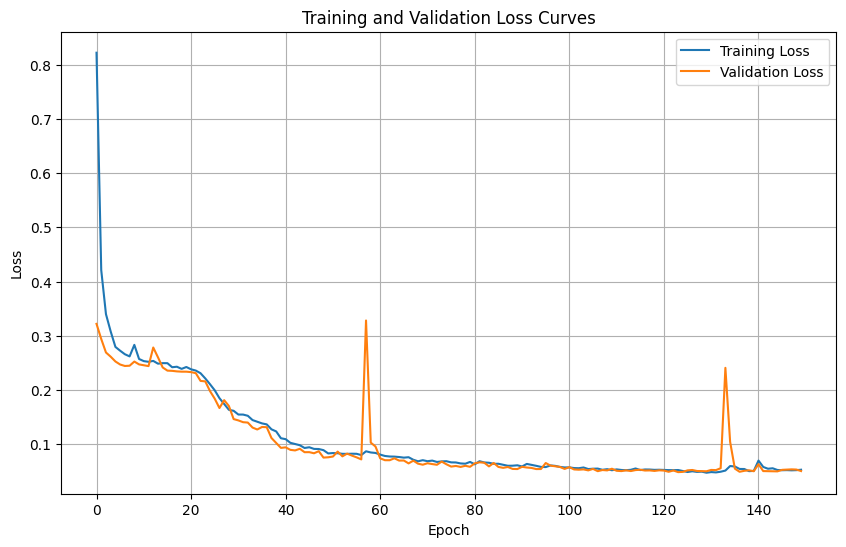

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Testing (Phase 1) 🏃

## Decision threshold

In [ ]:
ALPHA = 0.1 # @param {"type":"slider","min":0.1,"max":0.9,"step":0.1}

In [ ]:
import numpy as np
import torch

#Calculating threshold with N-sigma rule

def find_threshold_statistical(model, val_loader, device=None, alpha=0.5, k=3):
    """
    Calculates threshold using the statistical method (Mean + k*Std).
    Use this when the validation set contains ONLY normal images.

    Args:
        model: Trained Autoencoder
        val_loader: DataLoader containing ONLY normal images (subset of train)
        k (int): Number of standard deviations (default 3)
    """
    model.to(device)
    model.eval()

    normal_scores = []

    print("Calculating statistical threshold on normal validation data...")

    with torch.no_grad():
        for imgs in val_loader: # We ignore labels since we know they are all 0 (Normal)
            imgs = imgs.to(device)
            outputs = model(imgs)

            # Iterate through batch to get per-image scores
            for i in range(imgs.size(0)):
                img_single = imgs[i].unsqueeze(0)
                out_single = outputs[i].unsqueeze(0)

                # Calculate combined loss for this single image
                loss_val = combined_loss(out_single, img_single, alpha)
                normal_scores.append(loss_val.item())

    # Convert to numpy for stats
    scores = np.array(normal_scores)

    # 1. Calculate Statistics
    mu = np.mean(scores)
    sigma = np.std(scores)

    # 2. Calculate Threshold
    threshold = mu + (k * sigma)

    print(f"Stats -> Mean: {mu:.6f} | Std: {sigma:.6f}")
    print(f"Selected Threshold (Mean + {k}*Std): {threshold:.6f}")

    return threshold

## Model selection

In [ ]:
# Test model
test_model = AutoEncoder2D(input_resolution=size, in_channels=3, base_channels=base_ch_sel, z_dim=z_dim_sel).to(device)

# Define the path to your saved state_dict of the trained model you want to test
model_path = extract_path+"configh2.pth"

# --- Steps to load a model when only the state_dict was saved ---

# 1. Load the state_dict
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# 3. Load the state_dict into your instantiated model
test_model.load_state_dict(state_dict)

# 4. Set the model to evaluation mode
test_model.eval()

print("Model state_dict loading setup complete. Remember to instantiate your model and uncomment the loading lines.")

Model state_dict loading setup complete. Remember to instantiate your model and uncomment the loading lines.


## Test function

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

def evaluate_roc_auc_for_autoencoder(model, test_loader, device, alpha_loss=0.5):
    """
    Calculates ROC-AUC and PR-AUC for an autoencoder-based anomaly detection model.
    The anomaly score is derived from the combined reconstruction loss.
    """
    model.eval()
    all_labels = []
    all_anomaly_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate the anomaly score using the combined_loss function
            # Since batch_size is 1 for test_loader, this will be a scalar loss per image.
            anomaly_score = combined_loss(outputs, inputs, alpha_loss)

            all_anomaly_scores.append(anomaly_score.item())
            all_labels.append(labels.item())

    all_labels = np.array(all_labels)
    all_anomaly_scores = np.array(all_anomaly_scores)

    # ROC-AUC Calculation
    fpr, tpr, thresholds_roc = roc_curve(all_labels, all_anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # PR-AUC Calculation
    precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_anomaly_scores)
    pr_auc = average_precision_score(all_labels, all_anomaly_scores)

    return fpr, tpr, roc_auc, precision, recall, pr_auc

## ROC curve

In [ ]:
import matplotlib.pyplot as plt

def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Test execution

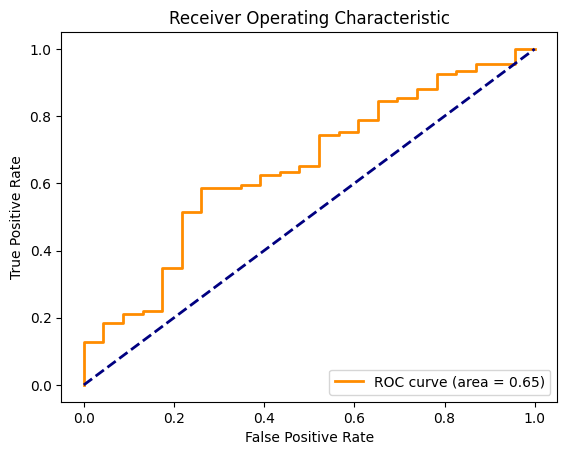

In [ ]:
fpr, tpr, roc_auc, precision, recall, pr_auc = evaluate_roc_auc_for_autoencoder(test_model, test_loader, device, alpha_loss=ALPHA)
plot_roc(fpr, tpr, roc_auc)

In [ ]:
print("Image level ROC-AUC:" + str(roc_auc))
print("Image level PR-AUC:" + str(pr_auc))

Image level ROC-AUC:0.6485839648982847
Image level PR-AUC:0.8969563489826894


## Confusion Matrix / Threshold search

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def test_autoencoder(model, device, test_loader, threshold, alpha=0.2):
  model.eval()
  tp = 0 #true positive
  tn = 0 #true negative
  fp = 0 #false positve
  fn = 0 #false negative
  with torch.no_grad():
    for data, target in test_loader:
      # Ensure target is a single value, as batch_size is 1
      target = target.item()
      data = data.to(device)
      output = model(data)
      #loss = torch.nn.functional.mse_loss(output, data, reduction='mean') # Use mean for comparison with threshold
      loss = combined_loss(output, data, alpha)
      if loss >= threshold: # Model predicts anomaly
        if target == 1: # Actual is anomaly
          tp += 1
        else: # Actual is normal
          fp += 1
      else: # Model predicts normal
        if target == 0: # Actual is normal
          tn += 1
        else: # Actual is anomaly
          fn += 1

  num_samples = len(test_loader.dataset)

  print(f'\nTest Results:')
  print(f'  True Positives (TP): {tp}')
  print(f'  True Negatives (TN): {tn}')
  print(f'  False Positives (FP): {fp}')
  print(f'  False Negatives (FN): {fn}')

  # Calculate metrics
  accuracy = (tp + tn) / num_samples if num_samples > 0 else 0
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  print(f'  Accuracy: {accuracy:.4f}')
  print(f'  Precision: {precision:.4f}')
  print(f'  Recall: {recall:.4f}')
  print(f'  F1-Score: {f1:.4f}')
  return f1

In [ ]:
thres=find_threshold_statistical(test_model, val_loader, device, alpha=ALPHA, k=1)

Calculating statistical threshold on normal validation data...
Stats -> Mean: 0.049961 | Std: 0.006180
Selected Threshold (Mean + 1*Std): 0.056141


In [ ]:
f1=test_autoencoder(test_model, device, test_loader, threshold=thres,alpha=ALPHA)


Test Results:
  True Positives (TP): 35
  True Negatives (TN): 19
  False Positives (FP): 4
  False Negatives (FN): 74
  Accuracy: 0.4091
  Precision: 0.8974
  Recall: 0.3211
  F1-Score: 0.4730


## Localization

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def generate_anomaly_heatmap(model, image_tensor, device, sigma=4):
    """
    Generates a localization heatmap using structural residuals.
    """
    model.eval()
    with torch.no_grad():
        # 1. Prepare data
        input_batch = image_tensor.unsqueeze(0).to(device)
        reconstruction = model(input_batch)

        # 3. Calculate Error Map (Absolute Difference)
        diff = torch.abs(input_batch - reconstruction)
        error_map = torch.mean(diff, dim=1).squeeze().cpu().numpy()

        # 4. Post-processing: Gaussian Blur for localization
        heatmap = gaussian_filter(error_map, sigma=sigma)

        # Normalize heatmap for visualization
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    return input_batch.squeeze().cpu(), reconstruction.squeeze().cpu(), heatmap

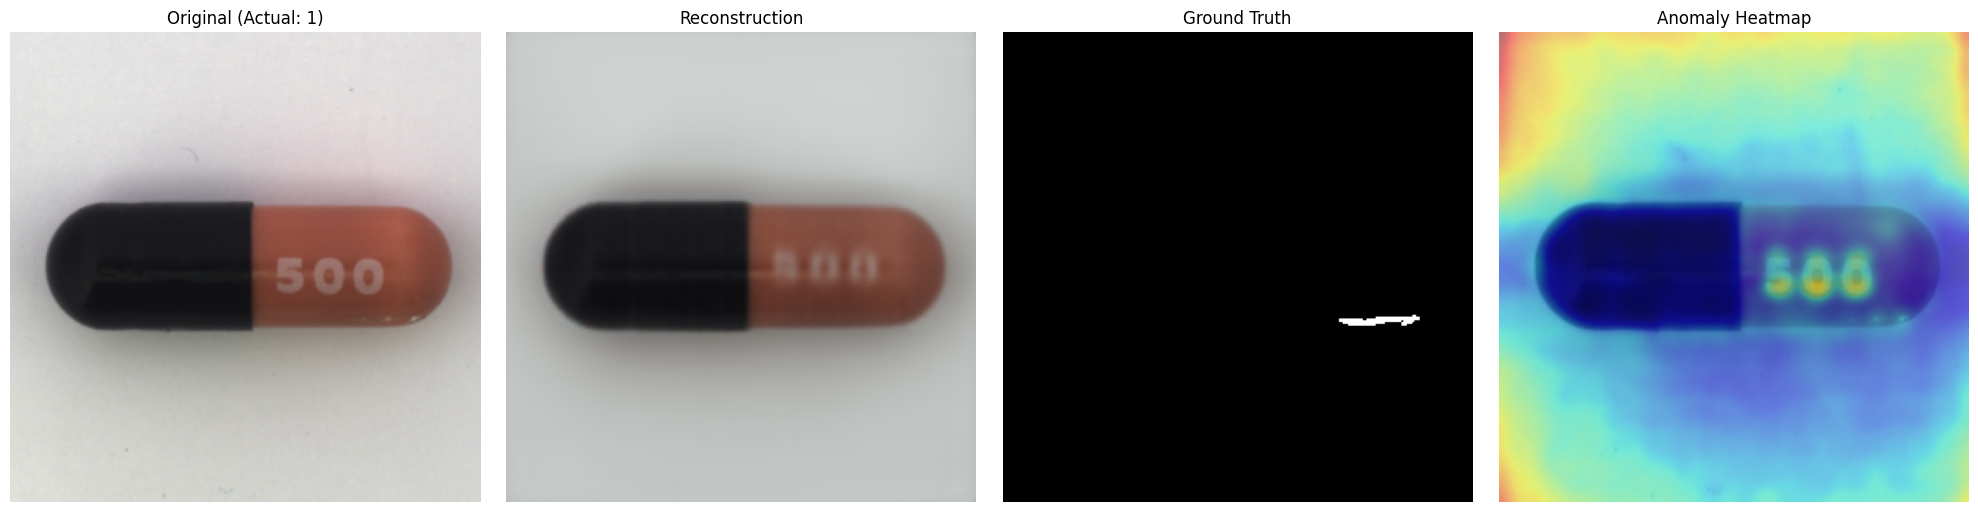

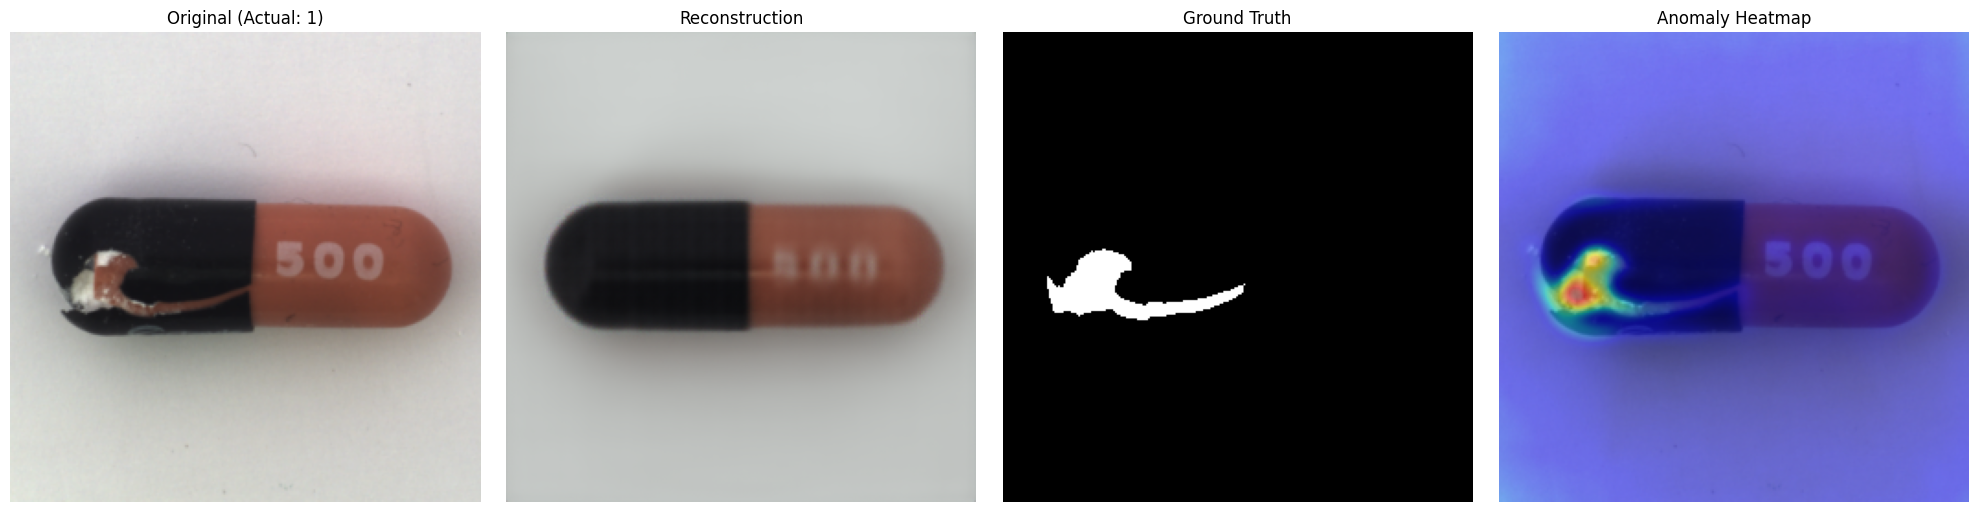

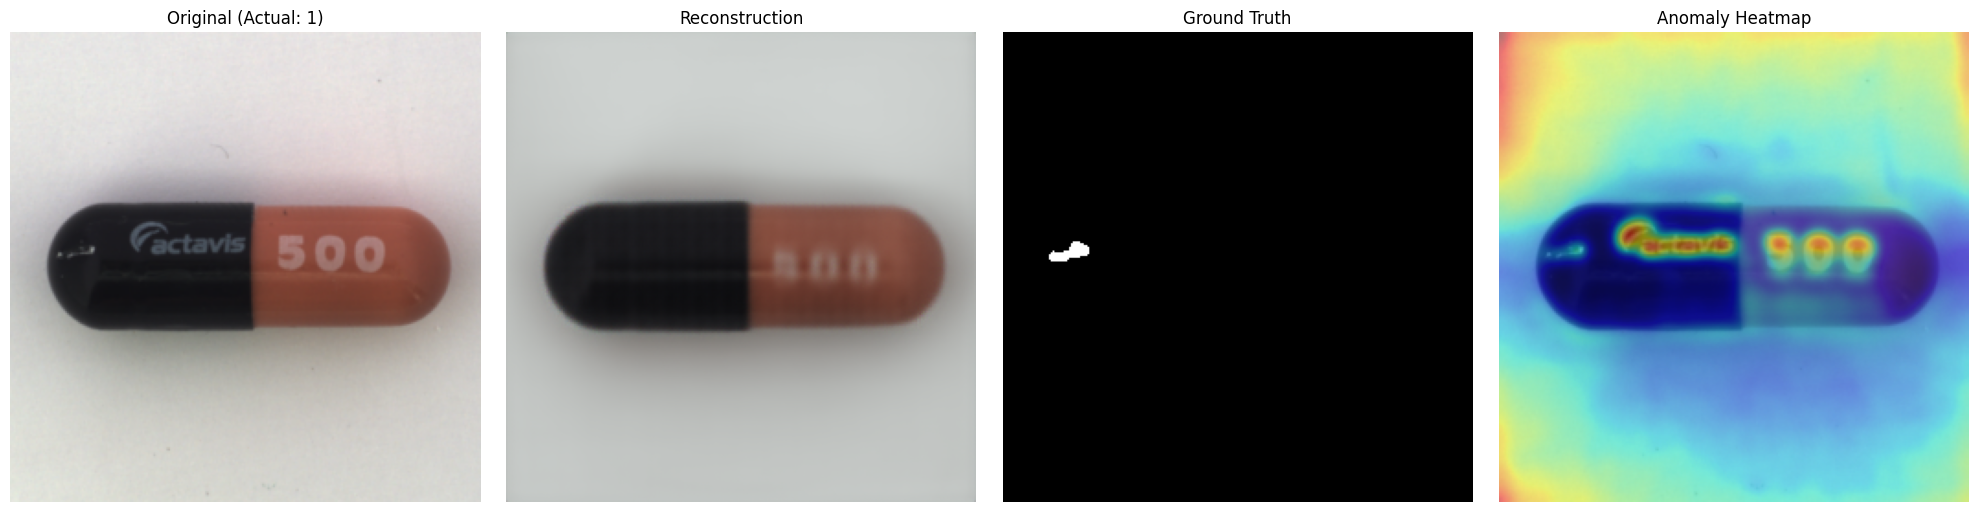

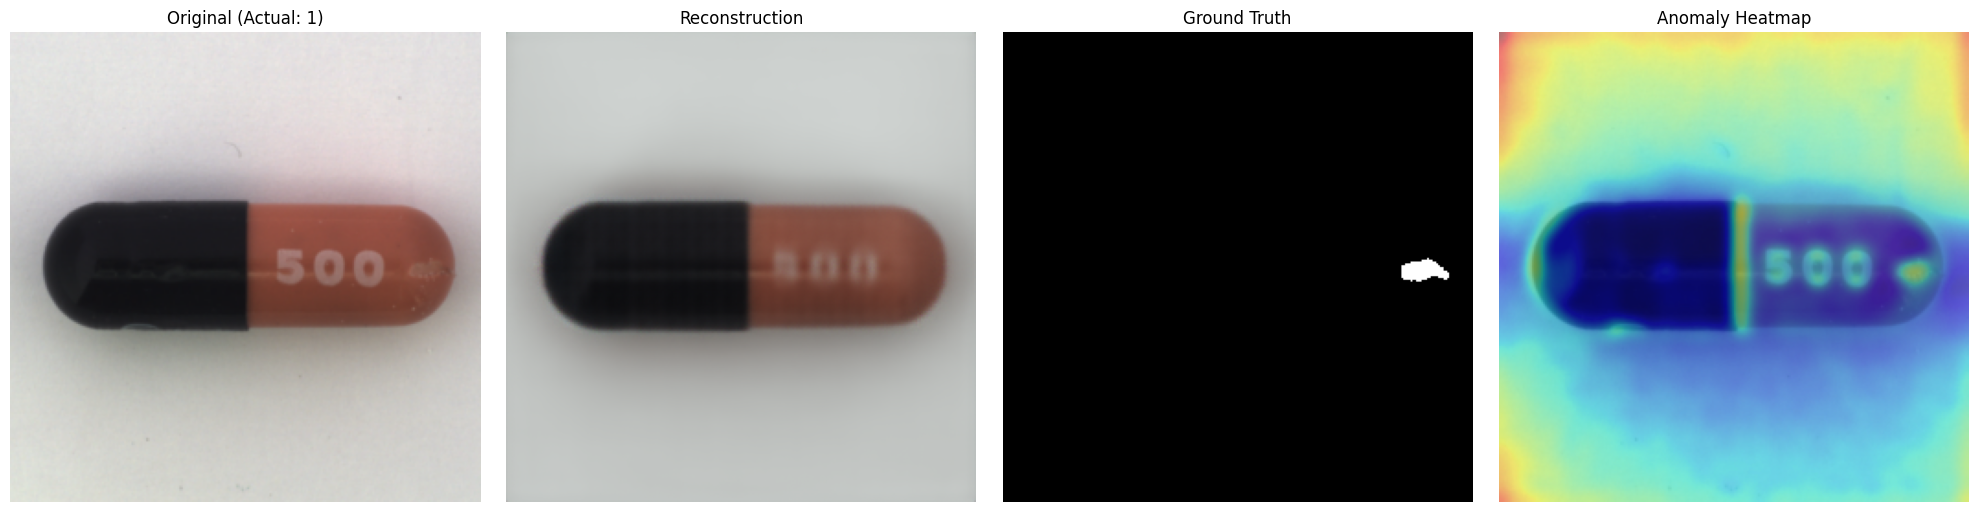

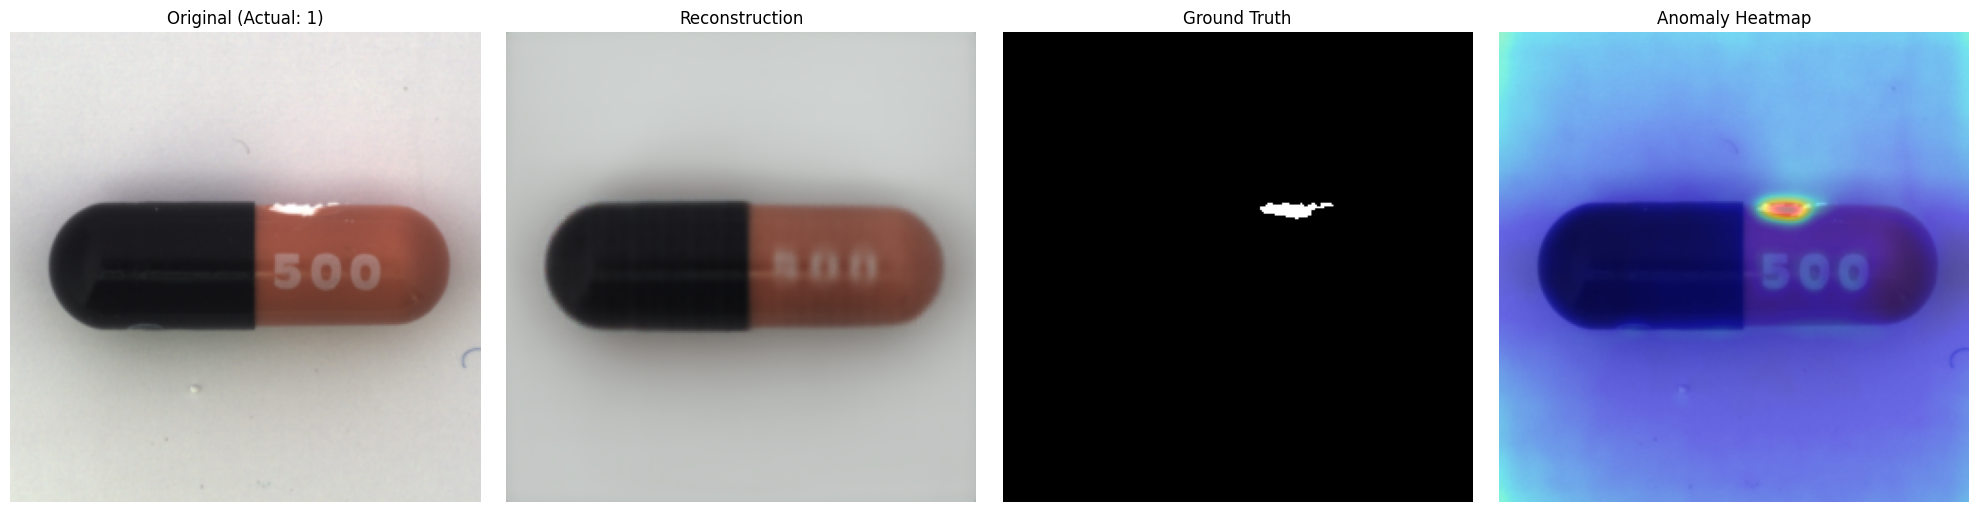

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2

# Redefine plot_heatmap_results within this cell to include classification details
def plot_heatmap_results(input_img, recon_img, heatmap, actual_label, ground_truth):
    """
    Visualizes original image, reconstruction, ground truth, and the anomaly heatmap overlay.
    Includes actual label in the title.
    """
    input_np = input_img.permute(1, 2, 0).numpy()
    recon_np = recon_img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(20, 5))

    # 1. Original Image
    plt.subplot(1, 4, 1)
    plt.title(f"Original (Actual: {actual_label})")
    plt.imshow(input_np)
    plt.axis('off')

    # 2. Reconstruction
    plt.subplot(1, 4, 2)
    plt.title("Reconstruction")
    plt.imshow(recon_np)
    plt.axis('off')

    # 3. Ground Truth
    plt.subplot(1, 4, 3)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='gray') # Display ground truth
    plt.axis('off')

    # 4. Anomaly Heatmap (Overlay)
    plt.subplot(1, 4, 4)
    plt.title("Anomaly Heatmap")
    plt.imshow(input_np) # Background original image
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # Heatmap overlay
    plt.axis('off')

    plt.tight_layout()
    plt.show()

num_samples_to_plot = 5
plotted_count = 0

# Using the last determined threshold for classification
# Removed classification_threshold as it's not used in the plotting itself

for i, (images, labels) in enumerate(test_loader):
    if plotted_count >= num_samples_to_plot:
        break

    # Only plot if it's an anomalous image (label 1)
    if labels.item() == 1:
        # Generate heatmap components
        input_img, recon_img, heatmap = generate_anomaly_heatmap(
            test_model, images.squeeze(0), device
        )

        # Retrieve ground truth mask for this image
        file_path = test_loader.dataset.file_list[i] # Get the current file path
        parts = file_path.split(os.sep)
        try:
            test_folder_idx = parts.index('test')
            defect_type = parts[test_folder_idx + 1] # e.g., 'crack', 'good'
        except (ValueError, IndexError):
            print(f"Warning: Could not determine defect type from path: {file_path}.")
            continue

        mask_filename = os.path.splitext(os.path.basename(file_path))[0] + '_mask.png'
        gt_path = os.path.join(extract_path, category, category, "ground_truth")
        mask_path = os.path.join(gt_path, defect_type, mask_filename)

        gt_mask = None
        if os.path.exists(mask_path):
            gt_mask_raw = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if gt_mask_raw is not None:
                # Resize to match the heatmap's dimensions if necessary
                if gt_mask_raw.shape[:2] != heatmap.shape[:2]: # Compare H, W
                    gt_mask_raw = cv2.resize(gt_mask_raw, (heatmap.shape[1], heatmap.shape[0]), interpolation=cv2.INTER_NEAREST)
                gt_mask = (gt_mask_raw > 128).astype(np.uint8) # Convert to binary mask
            else:
                print(f"Warning: Could not read mask image from {mask_path}.")
                continue
        else:
            print(f"Warning: Ground truth mask not found for {file_path}. Looked at: {mask_path}.")
            continue

        # Get actual label
        actual_label = labels.item()

        # Plot with classification and actual label
        plot_heatmap_results(input_img, recon_img, heatmap, actual_label, gt_mask)
        plotted_count += 1

# Domain Shift (Phase 2) ⚡

## Shifted dataset

### Training and validation-set

In [ ]:
#data augmentations for the training-set
image_train_transforms_shifted = transforms.Compose([
    transforms.Resize((500, 500)), # Create a buffer zone
    transforms.RandomPerspective(
        distortion_scale=0.3,
        p=0.8,
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=200 # Fill exposed areas with mid-gray
    ),
    transforms.RandomAffine(
        degrees=10,
        scale=(0.9, 1.0), # Allow slight zoom-in or no change, prevent zoom-out
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=200 # Fill exposed areas with mid-gray
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Moved after spatial transforms
    transforms.Resize((size, size)), # Final resize to target size, replacing CenterCrop
    transforms.ToTensor(),
])

#data augmentation on the validation-set
image_val_transforms_shifted = transforms.Compose([
    transforms.Resize((500, 500)), # Create a buffer zone
    transforms.RandomPerspective(
        distortion_scale=0.3,
        p=0.8,
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=200 # Fill exposed areas with mid-gray
    ),
    transforms.RandomAffine(
        degrees=10,
        scale=(0.9, 1.0), # Allow slight zoom-in or no change, prevent zoom-out
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=200 # Fill exposed areas with mid-gray
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Moved after spatial transforms
    transforms.Resize((size, size)), # Final resize to target size, replacing CenterCrop
    transforms.ToTensor(),
])

In [ ]:
train_data_shifted=MVTecDataset(train_list, transform=image_train_transforms_shifted)
val_data_shifted=MVTecDataset(val_list, transform=image_val_transforms_shifted)

train_loader_shifted=DataLoader(
    dataset=train_data_shifted,
    batch_size=batch_size,
    shuffle=True
)

val_loader_shifted=DataLoader(
    dataset=train_data_shifted,
    batch_size=1,
    shuffle=False #for validation
)

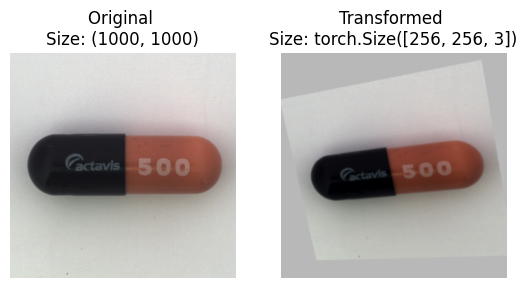

In [ ]:
random_image_path = train_list[2]
image_transformation_plot(random_image_path, image_train_transforms_shifted)

### Test dataset

In [ ]:
#Data augmentation for the test-set
image_test_transforms_shifted = transforms.Compose([
    transforms.Resize((500, 500)), # Create a buffer zone
    transforms.RandomPerspective(
        distortion_scale=0.3,
        p=0.8,
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=200 # Fill exposed areas with mid-gray
    ),
    transforms.RandomAffine(
        degrees=10,
        scale=(0.9, 1.0), # Allow slight zoom-in or no change, prevent zoom-out
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=200 # Fill exposed areas with mid-gray
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Moved after spatial transforms
    transforms.Resize((size, size)), # Final resize to target size, replacing CenterCrop
    transforms.ToTensor(),
])

In [ ]:
test_data_shifted=MVTecDatasetTest(test_list, transform=image_test_transforms_shifted)

test_loader_shifted=DataLoader(
    dataset=test_data_shifted,
    batch_size=1,
    shuffle=False #for validation
)

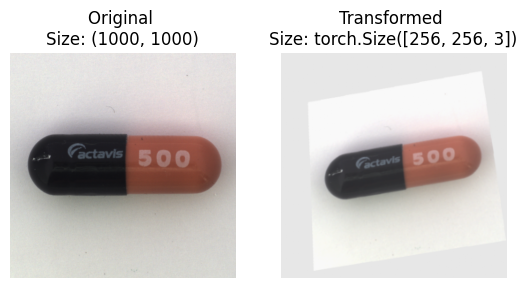

In [ ]:
random_image_path = test_list[2]
image_transformation_plot(random_image_path, image_test_transforms_shifted)

## Test under domain shift

### ROC-AUC and PR-AUC

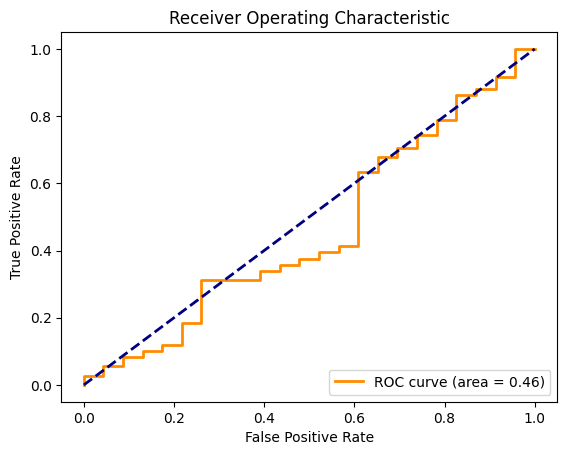

In [ ]:
fpr, tpr, roc_auc, precision, recall, pr_auc = evaluate_roc_auc_for_autoencoder(test_model, test_loader_shifted, device, alpha_loss=ALPHA)
plot_roc(fpr, tpr, roc_auc)

In [ ]:
print("Image level ROC-AUC:" + str(roc_auc))
print("Image level PR-AUC:" + str(pr_auc))

Image level ROC-AUC:0.4607100119664938
Image level PR-AUC:0.8143250692666603


### Thresholding

In [ ]:
f1=test_autoencoder(test_model, device, test_loader_shifted, threshold=thres,alpha=ALPHA)


Test Results:
  True Positives (TP): 109
  True Negatives (TN): 0
  False Positives (FP): 23
  False Negatives (FN): 0
  Accuracy: 0.8258
  Precision: 0.8258
  Recall: 1.0000
  F1-Score: 0.9046


### Heatmap

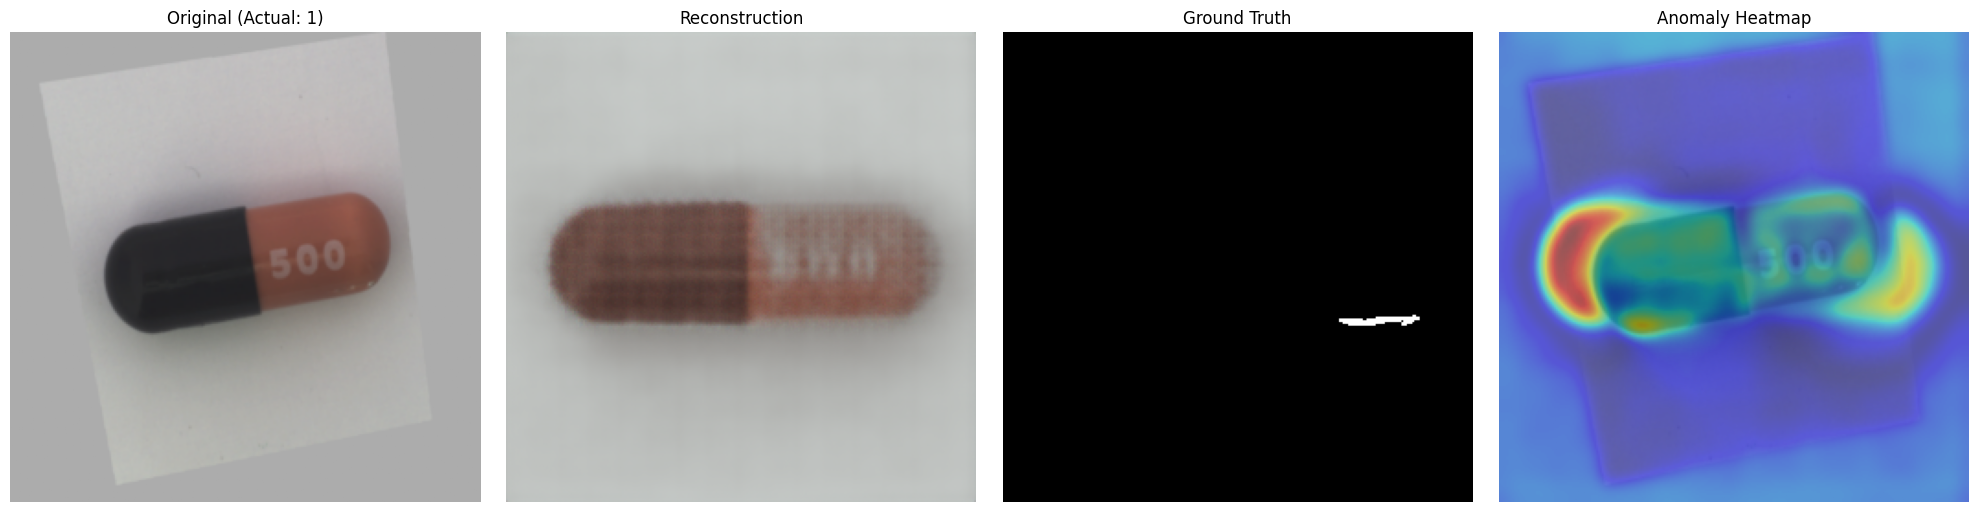

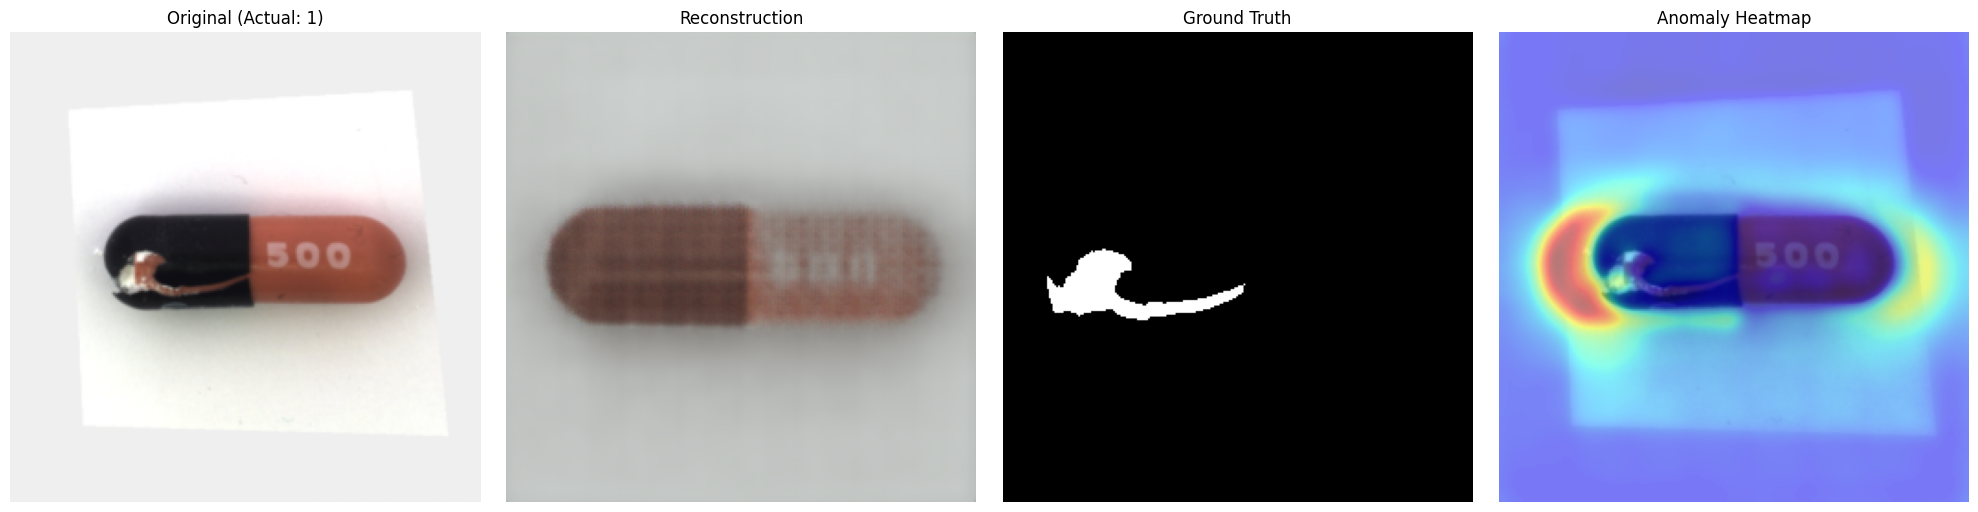

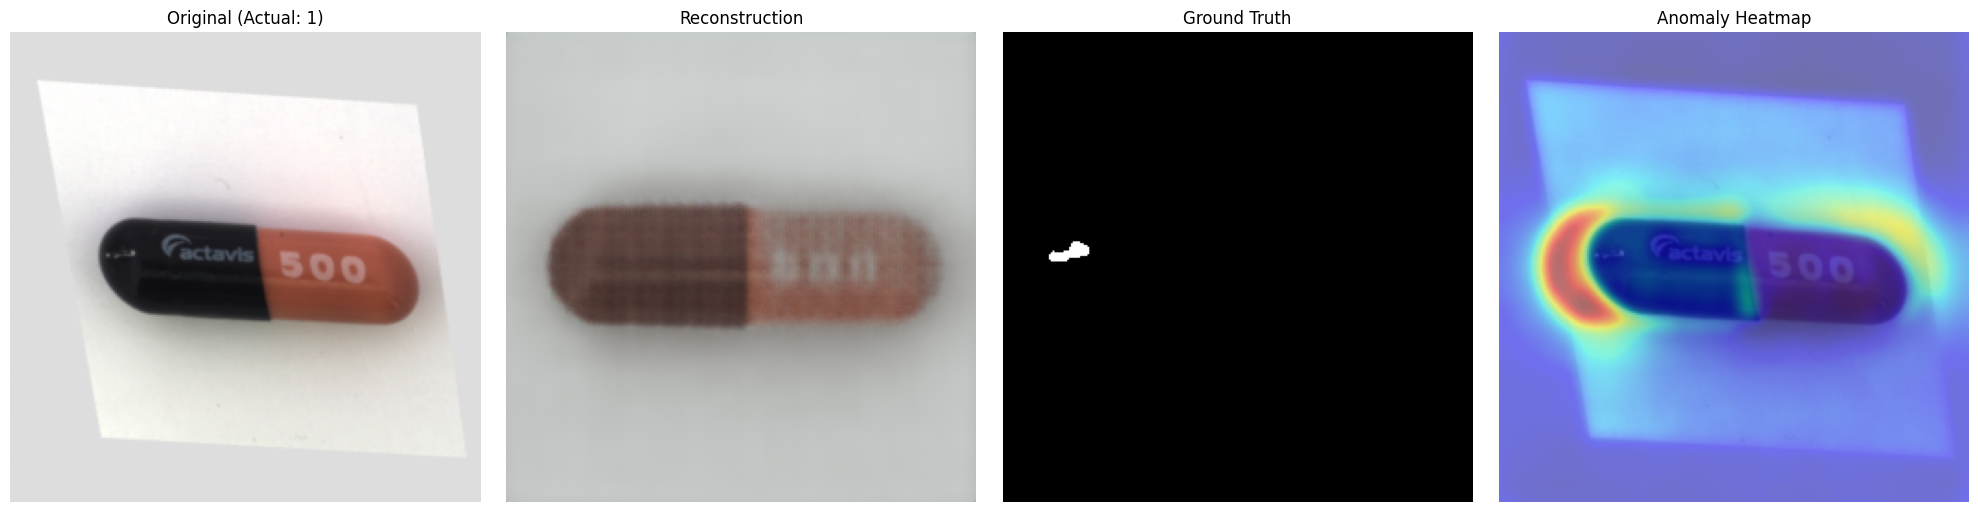

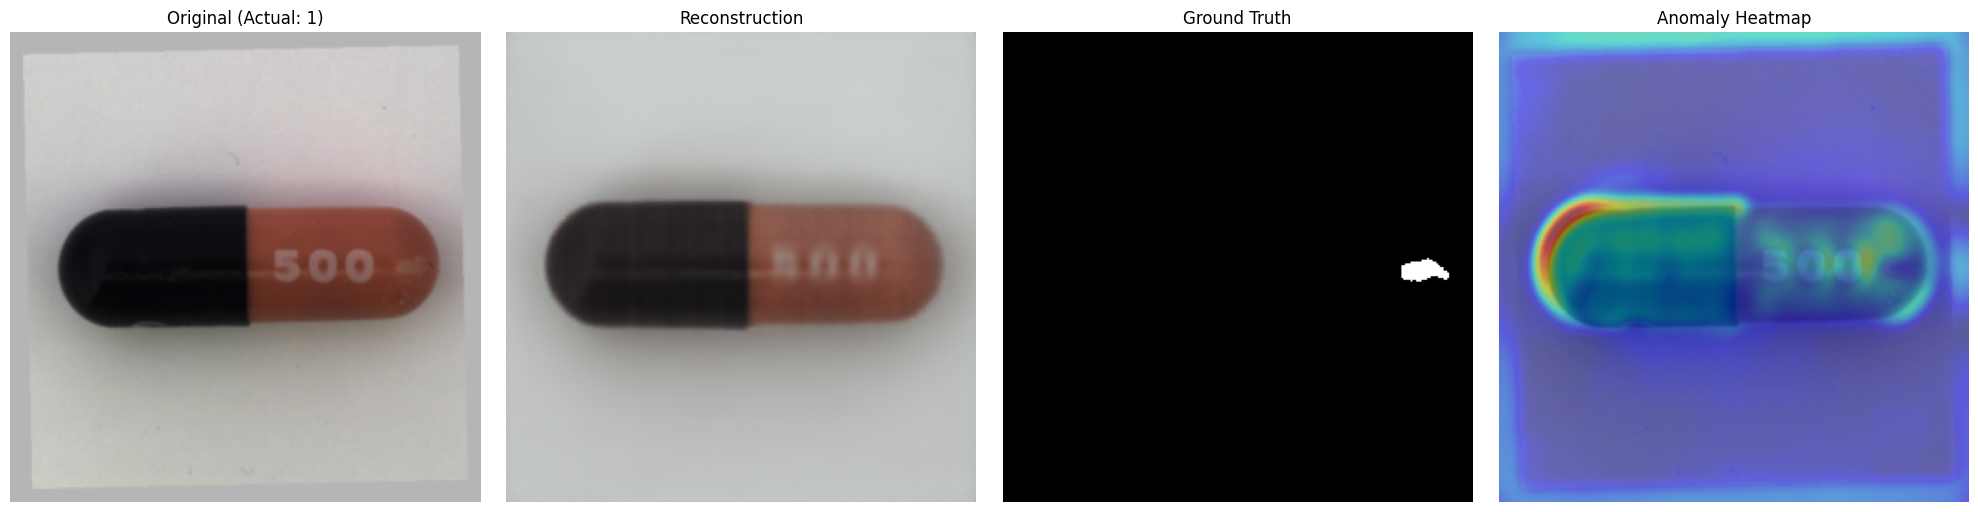

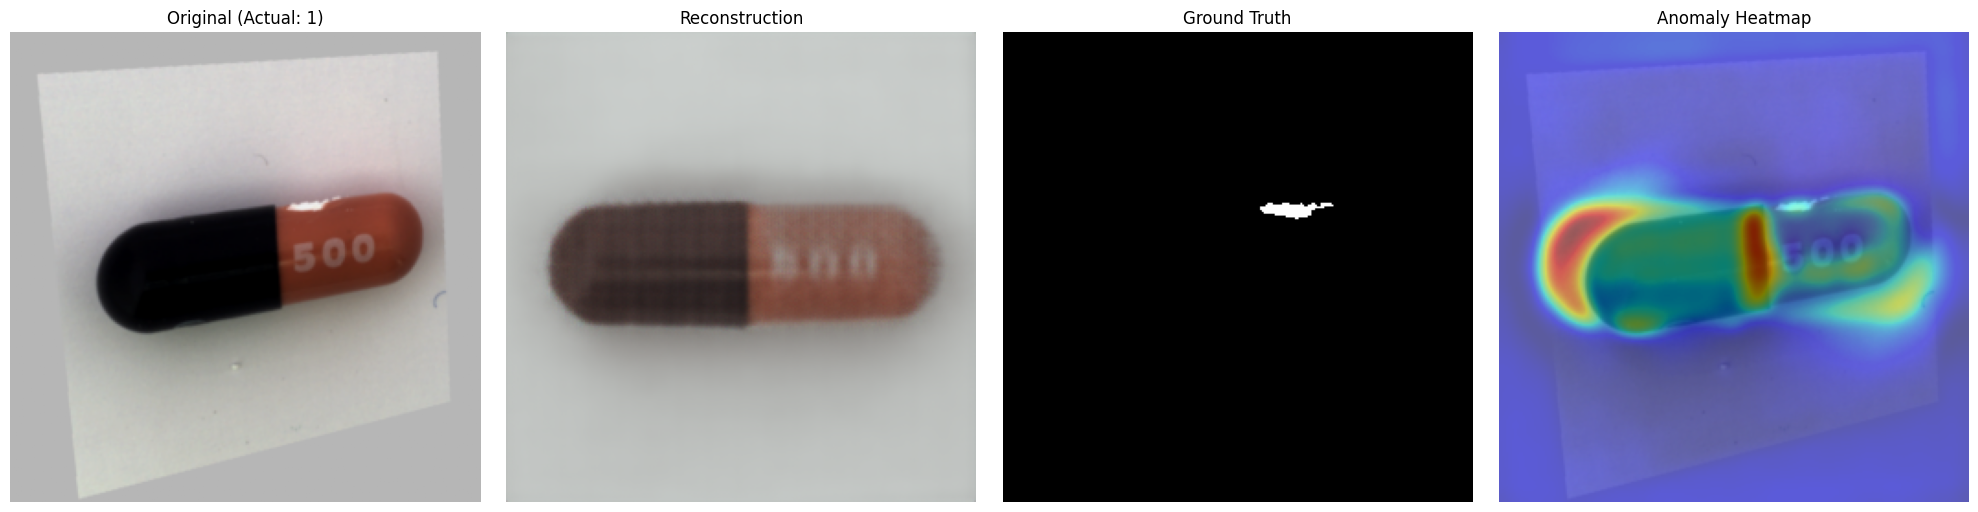

In [ ]:
num_samples_to_plot = 5
plotted_count = 0

# No longer need classification_threshold here, as it's removed from plot_heatmap_results

for i, (images, labels) in enumerate(test_loader_shifted):
    if plotted_count >= num_samples_to_plot:
        break

    # Only plot if it's an anomalous image (label 1)
    if labels.item() == 1:
        # Generate heatmap components
        input_img, recon_img, heatmap = generate_anomaly_heatmap(
            test_model, images.squeeze(0), device
        )

        # Retrieve ground truth mask for this image
        file_path = test_loader_shifted.dataset.file_list[i] # Get the current file path
        parts = file_path.split(os.sep)
        try:
            test_folder_idx = parts.index('test')
            defect_type = parts[test_folder_idx + 1] # e.g., 'crack', 'good'
        except (ValueError, IndexError):
            print(f"Warning: Could not determine defect type from path: {file_path}.")
            continue

        mask_filename = os.path.splitext(os.path.basename(file_path))[0] + '_mask.png'
        gt_path = os.path.join(extract_path, category, category, "ground_truth")
        mask_path = os.path.join(gt_path, defect_type, mask_filename)

        gt_mask = None
        if os.path.exists(mask_path):
            gt_mask_raw = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if gt_mask_raw is not None:
                # Resize to match the heatmap's dimensions if necessary
                if gt_mask_raw.shape[:2] != heatmap.shape[:2]: # Compare H, W
                    gt_mask_raw = cv2.resize(gt_mask_raw, (heatmap.shape[1], heatmap.shape[0]), interpolation=cv2.INTER_NEAREST)
                gt_mask = (gt_mask_raw > 128).astype(np.uint8) # Convert to binary mask
            else:
                print(f"Warning: Could not read mask image from {mask_path}.")
                continue
        else:
            print(f"Warning: Ground truth mask not found for {file_path}. Looked at: {mask_path}.")
            continue

        # Get actual label
        actual_label = labels.item()

        # Plot with actual label and ground truth
        plot_heatmap_results(input_img, recon_img, heatmap, actual_label, gt_mask)
        plotted_count += 1

## Training under domain shift

In [ ]:
#LOSS, MODEL AND OPTIMIZER, RUNNING TRAINING

model=AutoEncoder2D(input_resolution=size,base_channels=base_ch_sel,z_dim=z_dim_sel,in_channels=3).to(device)

#where to store the best model
model_name = "configds2" # @param {"type":"string","placeholder":"configf1"}
best_model_path=extract_path+model_name+".pth"

# HYPERPARAMETER SETUP FOR RUN 1
EFFECTIVE_BATCH_SIZE = 32 # @param {"type":"slider","min":1,"max":100,"step":1}
ACCUMULATION_STEPS = EFFECTIVE_BATCH_SIZE // batch_size # Automatically calculates 4 or 8
ALPHA = 0.1 # @param {"type":"slider","min":0.1,"max":0.9,"step":0.1}
LEARNING_RATE = 0.001 # @param {"type":"number","placeholder":"0.0001"}
W_DECAY = 1e-5 # @param {"type":"number","placeholder":"1e-5"}
EPOCHS = 150 # @param {"type":"slider","min":10,"max":1000,"step":10}

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=W_DECAY)

train_losses, val_losses = train_autoencoder_with_accumulation(
    model,
    optimizer,
    train_loader_shifted,
    val_loader_shifted,
    epochs=EPOCHS,                 # Give it time to converge
    accumulation_steps=ACCUMULATION_STEPS,
    device=device,
    save_best_path=best_model_path,
    alpha=ALPHA                  # Balanced start
)

### Train/validation loss-curve

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()